## Movie-Game Recommendation System
In this notebook, we build a cross-domain recommendation system between movies and games.
We use a deep learning approach, namely graph neural networks with Pytorch Geometric

We make use of two datasets:
- Movielens
  
  This dataset contains 9124 unique entries for movies,671 unique users, and 100000 entries for ratings of these movies.
- Steam game recommendations

  This dataset contains 50872 games with 41154793 ratings.

Both datasets can be found on kaggle at 

https://www.kaggle.com/datasets/rajmehra03/movielens100k 

and 

https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

In [ ]:
!pip install torch-geometric

In [2]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch.nn import Linear, ReLU, Dropout, BatchNorm1d
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt


### **Data Preprocessing**

In [3]:
movie_df = pd.read_csv('/kaggle/input/movielens100k/movies.csv')   # Contains movie metadata
movie_ratings_df = pd.read_csv('/kaggle/input/movielens100k/ratings.csv') # Contains userid, movieid, and rating
game_df = pd.read_json('/kaggle/input/game-recommendations-on-steam/games_metadata.json', lines=True) # Contains game metadata
game_ratings_df = pd.read_csv('/kaggle/input/game-recommendations-on-steam/recommendations.csv') # Contains gameid, userid,is_recommended


In [4]:
game_name_df = pd.read_csv('/kaggle/input/game-recommendations-on-steam/games.csv')
game_name_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [5]:
game_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


### **Find common UserIds of both datasets**

Since we do not have the same number of users in both datasets, we map the common userIds of the datasets and their corresponding features

In [6]:
distinct_user_ids = game_ratings_df['user_id'].unique()  
distinct_user_movie = movie_ratings_df['userId'].unique()

# Get the common user IDs
common_user_ids = np.intersect1d(distinct_user_ids, distinct_user_movie)

print(len(common_user_ids))


645


In [7]:
# Filter the DataFrames to include only common user IDs
filtered_user_game_df = game_ratings_df[game_ratings_df['user_id'].isin(common_user_ids)]
filtered_movie_user_df = movie_ratings_df[movie_ratings_df['userId'].isin(common_user_ids)]

filtered_user_game_df.head()


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
40805,1789480,14,6,2022-10-04,False,1.2,641,40805
52762,376210,2,0,2021-02-09,False,2.1,478,52762
54684,495420,0,0,2022-08-16,True,31.0,534,54684
64860,108600,0,0,2022-12-08,True,40.6,225,64860
67876,108600,0,0,2021-12-15,True,112.8,529,67876


 We split our data into training and testing sets

In [8]:
movie_train, movie_test = train_test_split(filtered_movie_user_df, test_size=0.2, random_state=42)
game_train, game_test = train_test_split(filtered_user_game_df, test_size=0.2, random_state=42)

We create our graph with movie, game, and user node. Each user node will be connected to a movie and game node with relationship 'recommended' 

In [9]:
# Map users, movies, and games to unique indices
user_ids = np.unique(np.concatenate((movie_train['userId'], game_train['user_id'])))
movie_ids = movie_train['movieId'].unique()
game_ids = game_train['app_id'].unique()

user_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_map = {movie_id: idx + len(user_map) for idx, movie_id in enumerate(movie_ids)}
game_map = {game_id: idx + len(user_map) + len(movie_map) for idx, game_id in enumerate(game_ids)}

# Combine edges and attributes
movie_edges = movie_train.apply(
    lambda row: [user_map[row['userId']], movie_map[row['movieId']]], axis=1
).tolist()
game_edges = game_train.apply(
    lambda row: [user_map[row['user_id']], game_map[row['app_id']]], axis=1
).tolist()
edges = movie_edges + game_edges
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Combine ratings
movie_ratings = movie_train['rating'].tolist()
game_ratings = game_train['is_recommended'].astype(float).tolist()
ratings = movie_ratings + game_ratings
edge_weight = torch.tensor(ratings, dtype=torch.float)
edge_weight = (edge_weight - edge_weight.min()) / (edge_weight.max() - edge_weight.min())

# Handle genres for movies
movie_df['genres'] = movie_df['genres'].fillna('').astype(str).str.split('|')
all_movie_genres = set([genre for genres in movie_df['genres'] for genre in genres])

# Handle genres for games
game_df['tags'] = game_df['tags'].apply(lambda x: x if isinstance(x, list) else [])
all_game_genres = set([genre for genres in game_df['tags'] for genre in genres])

# Combine all unique genres
all_genres = list(all_movie_genres.union(all_game_genres))
genre_map = {genre: idx for idx, genre in enumerate(all_genres)}

# Create genre features for movies
movie_genre_features = torch.zeros(len(movie_map), len(all_genres))
for _, row in movie_df.iterrows():
    movie_id = row['movieId']
    if movie_id in movie_map:
        for genre in row['genres']:
            if genre in genre_map:
                movie_genre_features[movie_map[movie_id] - len(user_map), genre_map[genre]] = 1

# Create genre features for games
game_genre_features = torch.zeros(len(game_map), len(all_genres))
for _, row in game_df.iterrows():
    game_id = row['app_id']
    if game_id in game_map:
        for genre in row['tags']:
            if genre in genre_map:
                game_genre_features[game_map[game_id] - len(user_map) - len(movie_map), genre_map[genre]] = 1

# Combine user, movie, and game features
num_users = len(user_map)
num_movies = len(movie_map)
num_games = len(game_map)

user_features = torch.eye(num_users)  # One-hot encoding for users
# One-hot encoding for users
user_features = torch.eye(num_users)  # Shape: [num_users, num_users]

# Add zero columns to user features to match the genre dimensions
user_genre_features = torch.zeros(num_users, len(all_genres))  # Shape: [num_users, num_genres]

# Combine user one-hot features with genre features
user_combined_features = torch.cat([user_features, user_genre_features], dim=1)  # Shape: [num_users, num_users + num_genres]

# Movie and game features already have genre dimensions
movie_combined_features = torch.cat([torch.zeros(len(movie_map), num_users), movie_genre_features], dim=1)  # Shape: [num_movies, num_users + num_genres]
game_combined_features = torch.cat([torch.zeros(len(game_map), num_users), game_genre_features], dim=1)  # Shape: [num_games, num_users + num_genres]

# Concatenate all features
node_features = torch.cat([user_combined_features, movie_combined_features, game_combined_features], dim=0)  # Shape: [num_nodes, num_users + num_genres]

# Define the graph data
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)



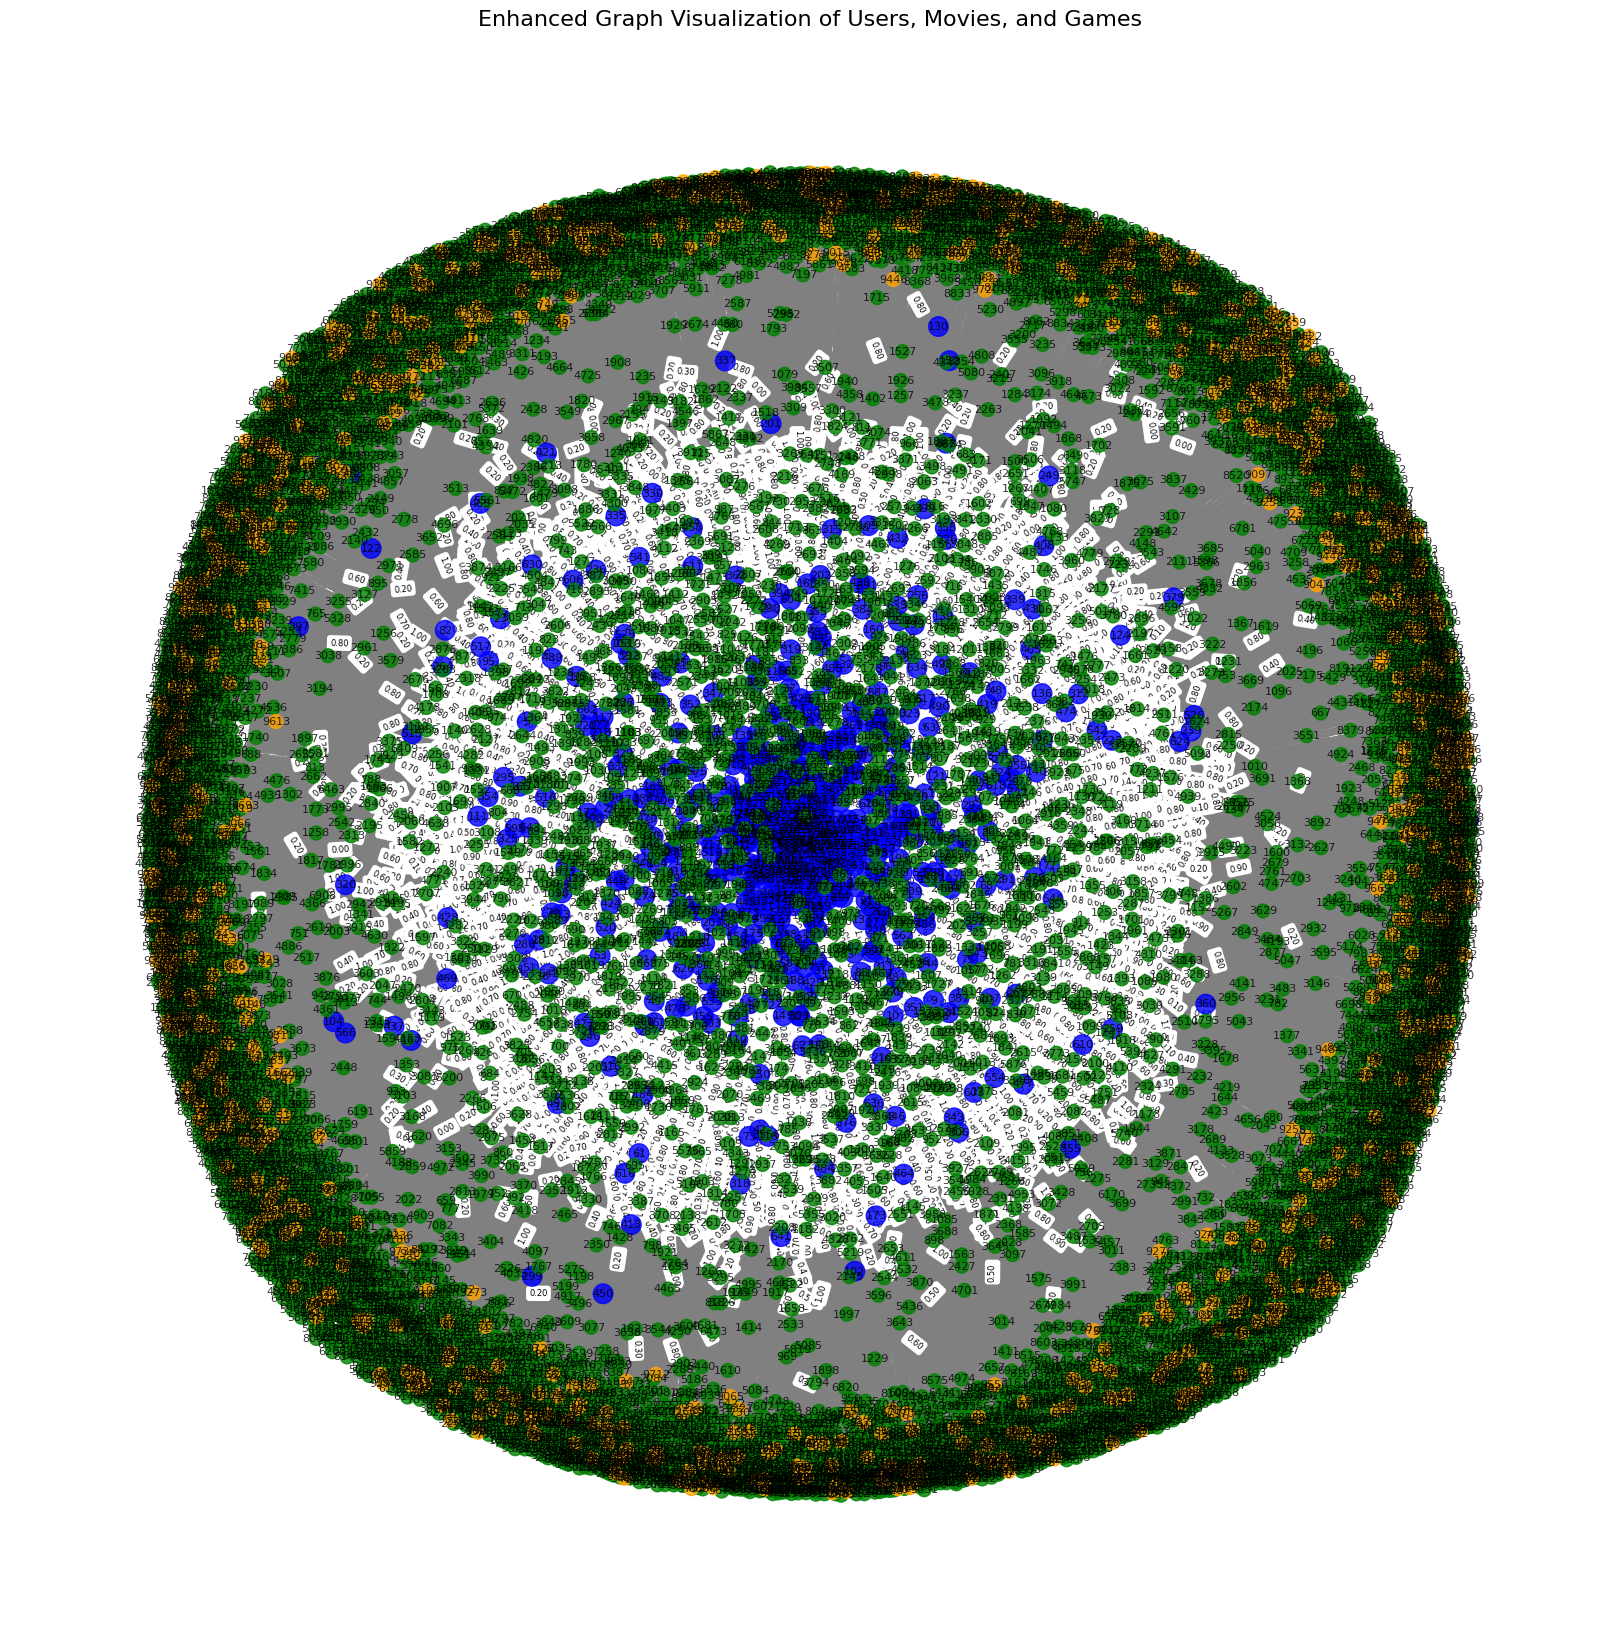

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Enhanced visualization function
def visualize_graph_improved(edge_index, edge_weights, num_users, num_movies, num_games):
    # Initialize a NetworkX graph
    G = nx.Graph()
    
    # Add user nodes
    for user_idx in range(num_users):
        G.add_node(user_idx, label=f"User-{user_idx}", color="blue", size=200)

    # Add movie nodes
    for movie_idx in range(num_movies):
        G.add_node(
            num_users + movie_idx,
            label=f"Movie-{movie_idx}",
            color="green",
            size=100
        )

    # Add game nodes
    for game_idx in range(num_games):
        G.add_node(
            num_users + num_movies + game_idx,
            label=f"Game-{game_idx}",
            color="orange",
            size=100
        )

    # Add edges with weights
    for i in range(edge_index.size(1)):
        source, target = edge_index[:, i]
        weight = edge_weights[i].item()
        G.add_edge(source.item(), target.item(), weight=weight)

    # Layout for better spacing
    pos = nx.spring_layout(G, seed=42, k=0.3)  # k adjusts spacing between nodes

    # Extract node attributes for color and size
    node_colors = [G.nodes[node]["color"] for node in G.nodes]
    node_sizes = [G.nodes[node]["size"] for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(16, 16))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        alpha=0.8,
        font_size=8,
    )

    # Add edge labels for weights
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_size=6
    )

    plt.title("Enhanced Graph Visualization of Users, Movies, and Games", fontsize=16)
    plt.show()

# Call the improved visualization function
visualize_graph_improved(edge_index, edge_weight, num_users, num_movies, num_games)



In [11]:
# Filter movie_test to ensure all userId and movieId exist in the maps
movie_test = movie_test[
    (movie_test['userId'].isin(user_map.keys())) & 
    (movie_test['movieId'].isin(movie_map.keys()))
]

# Filter game_test to ensure all user_id and app_id exist in the maps
game_test = game_test[
    (game_test['user_id'].isin(user_map.keys())) & 
    (game_test['app_id'].isin(game_map.keys()))
]

# Create test edges and attributes
movie_test_edges = movie_test.apply(
    lambda row: [user_map[row['userId']], movie_map[row['movieId']]], axis=1
).tolist()
game_test_edges = game_test.apply(
    lambda row: [user_map[row['user_id']], game_map[row['app_id']]], axis=1
).tolist()
test_edges = movie_test_edges + game_test_edges
test_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

# Combine test ratings
movie_test_ratings = movie_test['rating'].tolist()
game_test_ratings = game_test['is_recommended'].astype(float).tolist()
test_ratings = movie_test_ratings + game_test_ratings
test_edge_weight = torch.tensor(test_ratings, dtype=torch.float)

# Normalize the test ratings to match the same scale as training data
test_edge_weight = (test_edge_weight - edge_weight.min()) / (edge_weight.max() - edge_weight.min())

# Define the test data
test_data = Data(x=data.x, edge_index=test_edge_index, edge_attr=test_edge_weight)

We define our Graph Neural Network using PytorchG

In [12]:
class GNNRecommender(torch.nn.Module):
    def __init__(self, 
                 num_features:int,
                 hidden_channels:list,
                 classifier_hidden_dims:list,
                 use_dropout_in_conv:bool = True,
                 use_dropout_in_classifier:bool = True,
                 dropout_rate:float = 0.3,
                 use_input_masking:bool = True,
                 debug:bool = True):
        super(GNNRecommender, self).__init__()
        assert type(hidden_channels) in (list, tuple), "Expected a list or tuple for 'hidden_channels' arg" 

        self.debug = debug
        self.use_input_masking = use_input_masking
        self.use_dropout_in_classifier = use_dropout_in_classifier
        self.use_dropout_in_conv = use_dropout_in_conv
        self.dropout_rate = dropout_rate
        
        self.convs, self.conv_activations = self.build_conv_blocks(num_features, hidden_channels)
        self.classifier = self.build_classifier(hidden_channels[-1], classifier_hidden_dims)
        if use_input_masking:
            self.input_masking = Dropout(dropout_rate)

    def build_classifier(self, input_dim:int, hidden_dims:list):
        layers = []
        for hidden_dims_ in hidden_dims:
            layers.extend([
                Linear(input_dim, hidden_dims_)
            ])
            if self.use_dropout_in_classifier:
                layers.append(Dropout(self.dropout_rate))
            layers.append(ReLU())
            input_dim = hidden_dims_
        layers.append(Linear(input_dim, 1))
        return torch.nn.Sequential(*layers)

    def build_conv_blocks(self, input_channels:int, hidden_channels:list) -> tuple:
        convs = torch.nn.ModuleList()
        conv_activations = torch.nn.ModuleList()
        for hidden_channels_ in hidden_channels:
            convs.append(GCNConv(input_channels, hidden_channels_))
            conv_activation = [BatchNorm1d(hidden_channels_), ReLU()]
            if self.use_dropout_in_conv:
                conv_activation.append(Dropout(self.dropout_rate))
            conv_activations.append(torch.nn.Sequential(*conv_activation))
            input_channels = hidden_channels_
        return convs, conv_activations
        
    def forward(self, data, return_embeddings=False):
        """
        If return_embeddings=True, returns:
            node_embeddings (shape: [num_nodes, hidden_channels]), 
            final_predictions (shape: [num_nodes, 1])
        Otherwise, returns only the final_predictions.
        """
        x, edge_index = data.x, data.edge_index
        edge_attr = data.edge_attr  

        # -- GNN layers --
        if self.use_input_masking:
            x = self.input_masking(x)

        features_map = x
        for i in range(len(self.convs)):
            features_map = self.convs[i](features_map, edge_index)
            features_map = self.conv_activations[i](features_map)

        if self.debug:
            print(f"[DEBUG] Features map shape: {features_map.shape}")
        node_embeddings = features_map.clone()
        
        # -- Final MLP to get scalar predictions per node
        y = self.classifier(features_map)
        if self.debug:
            print(f"[DEBUG] Output shape: {y.shape}")
        
        if return_embeddings:
            return node_embeddings, y
        else:
            return y




In [13]:
from torchsummary import summary

# Adjust model initialization
model_args = {
    "num_features": data.num_node_features,
    "hidden_channels": [128, 256, 256, 512],
    "classifier_hidden_dims": [256],
    "use_dropout_in_conv": True,
    "use_dropout_in_classifier": True,
    "dropout_rate": 0.3,
    "use_input_masking": True,
    "debug": False
}
model = GNNRecommender(**model_args)


print(model)
# Optimizer and training setup (unchanged from your code)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.HuberLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)



GNNRecommender(
  (convs): ModuleList(
    (0): GCNConv(1093, 128)
    (1): GCNConv(128, 256)
    (2): GCNConv(256, 256)
    (3): GCNConv(256, 512)
  )
  (conv_activations): ModuleList(
    (0): Sequential(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (1-2): 2 x Sequential(
      (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (3): Sequential(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
  (input_masking): Dropout(p=0.3, inplace=False)
)


In [14]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.edge_index[0]].squeeze(), data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

def calculate_metrics(pred, true):
    pred = pred.squeeze().detach().cpu()
    true = true.detach().cpu()
    rmse = torch.sqrt(torch.mean((pred - true) ** 2))
    mae = torch.mean(torch.abs(pred - true))
    return rmse.item(), mae.item()


def test():
    model.eval()
    with torch.no_grad():
        # Get predictions for the test dataset
        out = model(data)
        pred = out[data.edge_index[0]]
        rmse, mae = calculate_metrics(pred, data.edge_attr)
    return pred, rmse, mae

# Training with early stopping
best_rmse = float('inf')
patience = 0
max_patience = 20

train_losses = []
test_rmses = []
test_maes = []

for epoch in range(60):
    loss = train()
    pred, rmse, mae = test()
    
    scheduler.step(rmse)
    
    train_losses.append(loss)
    test_rmses.append(rmse)
    test_maes.append(mae)

    print(f"Epoch {epoch}, Loss: {loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        patience = 0
        torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
    else:
        patience += 1
        
    if patience >= max_patience:
        print("Early stopping!")
        break

# Load the best model
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))



Epoch 0, Loss: 0.1943, RMSE: 0.6684, MAE: 0.6312
Epoch 1, Loss: 0.1759, RMSE: 0.6138, MAE: 0.5738
Epoch 2, Loss: 0.0901, RMSE: 0.5908, MAE: 0.5496
Epoch 3, Loss: 0.0341, RMSE: 0.5841, MAE: 0.5426
Epoch 4, Loss: 0.0529, RMSE: 0.5769, MAE: 0.5350
Epoch 5, Loss: 0.0616, RMSE: 0.5556, MAE: 0.5125
Epoch 6, Loss: 0.0680, RMSE: 0.5195, MAE: 0.4767
Epoch 7, Loss: 0.0549, RMSE: 0.4753, MAE: 0.4332
Epoch 8, Loss: 0.0380, RMSE: 0.4211, MAE: 0.3797
Epoch 9, Loss: 0.0318, RMSE: 0.3678, MAE: 0.3259
Epoch 10, Loss: 0.0361, RMSE: 0.3228, MAE: 0.2848
Epoch 11, Loss: 0.0370, RMSE: 0.2920, MAE: 0.2543
Epoch 12, Loss: 0.0374, RMSE: 0.2773, MAE: 0.2400
Epoch 13, Loss: 0.0408, RMSE: 0.2732, MAE: 0.2358
Epoch 14, Loss: 0.0369, RMSE: 0.2789, MAE: 0.2416
Epoch 15, Loss: 0.0316, RMSE: 0.2890, MAE: 0.2514
Epoch 16, Loss: 0.0304, RMSE: 0.3024, MAE: 0.2645
Epoch 17, Loss: 0.0323, RMSE: 0.3138, MAE: 0.2760
Epoch 18, Loss: 0.0316, RMSE: 0.3200, MAE: 0.2821
Epoch 19, Loss: 0.0334, RMSE: 0.3203, MAE: 0.2824
Epoch 20, 

<ipython-input-14-881989585364>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))


<All keys matched successfully>

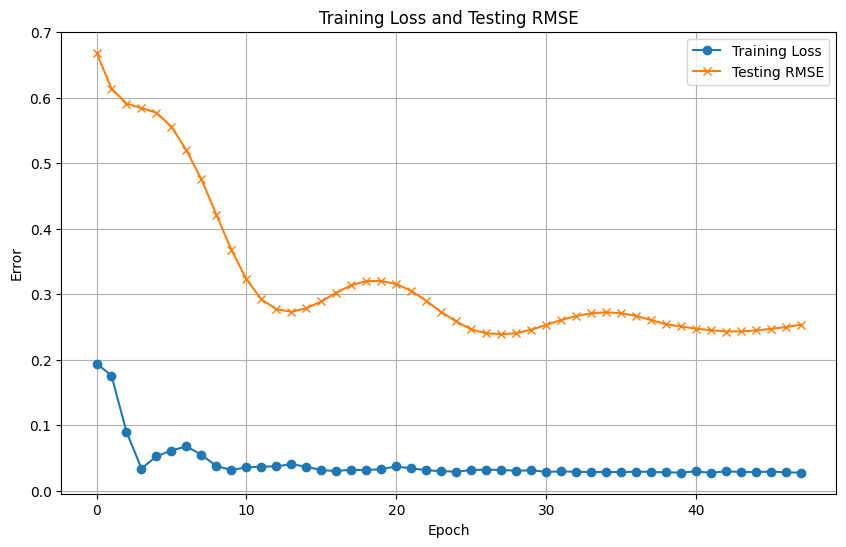

In [15]:
# Plot training loss and testing RMSE
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', marker='o')
plt.plot(range(len(test_rmses)), test_rmses, label='Testing RMSE', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training Loss and Testing RMSE')
plt.legend()
plt.grid()
plt.show()

In [16]:
def get_recommendations(user_id, top_k=10):
    model.eval()

    # Map the user ID to the internal user ID
    internal_user_id = user_map[user_id]

    # Get movies and games rated by the user
    rated_movies = set(movie_test[movie_test.userId == user_id]['movieId'])
    rated_games = set(game_test[game_test.user_id == user_id]['app_id'])

    # Get all movies and games
    all_movies = set(movie_map.keys())
    all_games = set(game_map.keys())

    # Determine unwatched/unrated movies and games
    unwatched_movies = all_movies - rated_movies
    unrated_games = all_games - rated_games

    # Create test edges for movies and games
    test_movie_edges = [[internal_user_id, movie_map[movie_id]] for movie_id in unwatched_movies]
    test_game_edges = [[internal_user_id, game_map[game_id]] for game_id in unrated_games]
    test_edges = test_movie_edges + test_game_edges
    test_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

    with torch.no_grad():
        test_data = Data(x=data.x, edge_index=test_edge_index)
        predictions = model(test_data)

    # Rescale predictions to the original range of edge weights
    predictions = predictions.squeeze()
    original_min = edge_weight.min()
    original_max = edge_weight.max()
    predictions = predictions * (original_max - original_min) + original_min

    # Separate movie and game predictions
    num_movie_edges = len(test_movie_edges)
    movie_predictions = predictions[:num_movie_edges].tolist()
    game_predictions = predictions[num_movie_edges:].tolist()

    # Combine movie and game predictions with their respective IDs
    movie_recommendations = list(zip(unwatched_movies, movie_predictions))
    game_recommendations = list(zip(unrated_games, game_predictions))

    # Sort by predicted rating and select the top 5 movies and top 5 games
    top_movie_recommendations = sorted(movie_recommendations, key=lambda x: x[1], reverse=True)[:5]
    top_game_recommendations = sorted(game_recommendations, key=lambda x: x[1], reverse=True)[:5]

    # Fetch movie and game titles
    recommended_items = []
    for item_id, pred_rating in top_movie_recommendations:
        movie_info = movie_df[movie_df.movieId == item_id]
        movie_title = movie_info['title'].iloc[0] if not movie_info.empty else f"Unknown Movie ({item_id})"
        recommended_items.append({
            'type': 'Movie',
            'id': item_id,
            'title': movie_title,
            'predicted_rating': round(pred_rating, 2)
        })

    for item_id, pred_rating in top_game_recommendations:
        game_info = game_name_df[game_name_df['app_id'] == item_id]
        game_title = game_info['title'].iloc[0] if not game_info.empty else f"Unknown Game ({item_id})"
        recommended_items.append({
            'type': 'Game',
            'id': item_id,
            'title': game_title,
            'predicted_rating': round(pred_rating, 2)
        })

    return recommended_items



In [24]:
user_id = 20
recommendations = get_recommendations(user_id, top_k=10)

print(f"\nTop 10 Recommendations (User ID: {user_id}):")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. [{rec['type']}] {rec['title']} (Estimated Rating: {rec['predicted_rating']:.2f})")



Top 10 Recommendations (User ID: 20):
1. [Movie] Celluloid Closet, The (1995) (Estimated Rating: 0.63)
2. [Movie] Specialist, The (1994) (Estimated Rating: 0.63)
3. [Movie] Before the Rain (Pred dozhdot) (1994) (Estimated Rating: 0.62)
4. [Movie] Misérables, Les (1995) (Estimated Rating: 0.62)
5. [Movie] Mrs. Winterbourne (1996) (Estimated Rating: 0.62)
6. [Game] Deus Ex: Human Revolution - Director's Cut (Estimated Rating: 0.58)
7. [Game] Titanfall® 2 (Estimated Rating: 0.58)
8. [Game] LOTUS-Simulator (Estimated Rating: 0.58)
9. [Game] Google Earth VR (Estimated Rating: 0.58)
10. [Game] Blasphemous (Estimated Rating: 0.58)


In [25]:
def get_recommendations_from_liked_items(liked_items, top_k=10):
   
    model.eval()

    # Extract liked movies and games
    liked_movies = liked_items.get('movies', [])
    liked_games = liked_items.get('games', [])

    # Map the liked items to their internal IDs
    liked_movie_edges = [[movie_map[movie_id], movie_map[movie_id]] for movie_id in liked_movies if movie_id in movie_map]
    liked_game_edges = [[game_map[game_id], game_map[game_id]] for game_id in liked_games if game_id in game_map]

    # Get all movies and games
    all_movies = set(movie_map.keys())
    all_games = set(game_map.keys())

    # Determine unwatched/unrated movies and games
    unwatched_movies = all_movies - set(liked_movies)
    unrated_games = all_games - set(liked_games)

    # Create test edges for movies and games
    test_movie_edges = [[movie_map[movie_id], movie_map[movie_id]] for movie_id in unwatched_movies]
    test_game_edges = [[game_map[game_id], game_map[game_id]] for game_id in unrated_games]
    test_edges = test_movie_edges + test_game_edges
    test_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

    with torch.no_grad():
        test_data = Data(x=data.x, edge_index=test_edge_index)
        predictions = model(test_data)

    # Rescale predictions to the original range of edge weights
    predictions = predictions.squeeze()
    original_min = edge_weight.min()
    original_max = edge_weight.max()
    predictions = predictions * (original_max - original_min) + original_min

    # Separate movie and game predictions
    num_movie_edges = len(test_movie_edges)
    movie_predictions = predictions[:num_movie_edges].tolist()
    game_predictions = predictions[num_movie_edges:].tolist()

    # Combine movie and game predictions with their respective IDs
    movie_recommendations = list(zip(unwatched_movies, movie_predictions))
    game_recommendations = list(zip(unrated_games, game_predictions))

    # Sort by predicted rating and select the top 5 movies and top 5 games
    top_movie_recommendations = sorted(movie_recommendations, key=lambda x: x[1], reverse=True)[:5]
    top_game_recommendations = sorted(game_recommendations, key=lambda x: x[1], reverse=True)[:5]

    # Fetch movie and game titles
    recommended_items = []
    for item_id, pred_rating in top_movie_recommendations:
        movie_info = movie_df[movie_df.movieId == item_id]
        movie_title = movie_info['title'].iloc[0] if not movie_info.empty else f"Unknown Movie ({item_id})"
        recommended_items.append({
            'type': 'Movie',
            'id': item_id,
            'title': movie_title,
            'predicted_rating': round(pred_rating, 2)
        })

    for item_id, pred_rating in top_game_recommendations:
        game_info = game_name_df[game_name_df['app_id'] == item_id]
        game_title = game_info['title'].iloc[0] if not game_info.empty else f"Unknown Game ({item_id})"
        recommended_items.append({
            'type': 'Game',
            'id': item_id,
            'title': game_title,
            'predicted_rating': round(pred_rating, 2)
        })

    return recommended_items


liked_items = {
    'movies': [10, 202, 404],
    'games': [505, 606]
}
recommendations = get_recommendations_from_liked_items(liked_items, top_k=10)

print("\nRecommendations based on liked items:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. [{rec['type']}] {rec['title']}(Estimated Rating: {rec['predicted_rating']:.2f})")



Recommendations based on liked items:
1. [Movie] Andre (1994)(Estimated Rating: 0.63)
2. [Movie] Specialist, The (1994)(Estimated Rating: 0.63)
3. [Movie] Before Sunrise (1995)(Estimated Rating: 0.62)
4. [Movie] Misérables, Les (1995)(Estimated Rating: 0.62)
5. [Movie] Operation Dumbo Drop (1995)(Estimated Rating: 0.62)
6. [Game] Sonic Generations Collection(Estimated Rating: 0.63)
7. [Game] SCUM(Estimated Rating: 0.63)
8. [Game] LOTUS-Simulator(Estimated Rating: 0.63)
9. [Game] 7 Days to Die(Estimated Rating: 0.63)
10. [Game] DUSK(Estimated Rating: 0.63)
